<img src='https://www.met.no/om-oss/logo/_/image/73f29cde-219f-487b-809c-9cdd61032c78:2efc46ce776f5f5337c4b0156ae0cbaa3b6bf6fe/width-768/Met_RGB_Horisontal.jpg' width=200 align=right>
<img src='https://raw.githubusercontent.com/norkyst/norkyst-logo/refs/heads/main/png/horizontal_35_91_100.png' width=200 align=right>

# Simple timeseries examples using Norkyst v3

This notebook will give examples on how to use data from the Norkyst v3 ocean model to make timeseries. Data is accessed through the Norwegian Meteorological Insitute's THREDDS server: https://thredds.met.no/thredds/fou-hi/norkystv3.html.

__Python requirements__:
To access the model output data we will use:
* `xarray` for for opening and reading the netCDF files, see: https://docs.xarray.dev/en/stable/user-guide/index.html
* `Matplotlib` for plotting, see: https://matplotlib.org/stable/users/index.html
* `NumPy` for calculations on arrays, see: https://numpy.org/doc/
* `xroms` for special functions made for ROMS output files, see: https://xroms.readthedocs.io
* `Cartopy`for plotting on maps, see: https://scitools.org.uk/cartopy/docs/latest/

In [1]:
# Importing useful Python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import xroms
import metpy

#mplstyle.use(['ggplot', 'fast'])

### Accessing the data
Data can be found at https://thredds.met.no/thredds/catalog.html.
Locate project, folder and files. Here we will use OPENDAP url to read in the data.
To get the OPENDAP URL, click on the desired NetCDF file (.nc). Under the "ACCESS" section, select the OPENDAP URL and then copy the URL located under "DATA URL".

For more details on the model and data, see the notebook `about_norkystv3.ipynb`.

In [2]:
# Reading in the path from thredds.met.no, using an OPENDAP url
path = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkystv3_800m_m00_be'

# Opening a netCDF file as xarray dataset
ds = xr.open_dataset(path)

# Viewing the dataset
ds

<xarray.Dataset>
Dimensions:                  (X: 2747, Y: 1148, depth: 15, time: 841)
Coordinates:
  * X                        (X) int32 0 800 1600 ... 2195200 2196000 2196800
  * Y                        (Y) int32 0 800 1600 2400 ... 916000 916800 917600
  * depth                    (depth) float64 0.0 1.0 2.0 ... 100.0 200.0 300.0
  * time                     (time) datetime64[ns] 2025-07-12 ... 2025-08-16
    lon                      (Y, X) float64 ...
    lat                      (Y, X) float64 ...
Data variables:
    projection_stere         int32 ...
    forecast_reference_time  datetime64[ns] ...
    h                        (Y, X) float64 ...
    zeta                     (time, Y, X) float32 ...
    u_eastward               (time, depth, Y, X) float32 ...
    v_northward              (time, depth, Y, X) float32 ...
    w                        (time, depth, Y, X) float32 ...
    temperature              (time, depth, Y, X) float32 ...
    salinity                 (time, depth, Y, X) float32 ...
    AKs                      (time, depth, Y, X) float32 ...
    Uwind_eastward           (time, Y, X) float32 ...
    Vwind_northward          (time, Y, X) float32 ...
Attributes: (12/40)
    id:                         4c453da7-51f0-493c-8b76-ab622b656be5
    naming_authority:           no.met
    operational_status:         Operational
    iso_topic_category:         oceans
    activity_type:              Numerical Simulation
    keywords_vocabulary:        GCMDSK:GCMD Science Keywords:https://gcmd.ear...
    ...                         ...
    summary:                    Norkyst_v3-800m (Norwegian Coast 800m horizon...
    title_no:                   120 timers prognoser fra havmodellen Norkyst_...
    summary_no:                 NorKyst_v3-800m (Norske kystområder med 800m ...
    contributor_name:           Magne Simonsen, Mateusz Matuszak
    contributor_role:           Technical contact, Metadata author
    contributor_email:          magnes@met.no, mateuszm@met.no

For starters, we can with only one line make a simple timeseries plot:

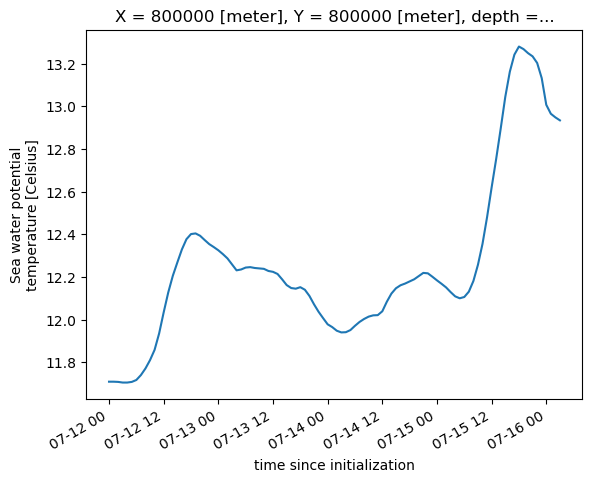

In [3]:
ds.temperature.isel(time=slice(0,100) ,X=1000, Y=1000, depth=0).plot()

Further, we will look at examples of how to make timeseries from a given point location within the domain.

In [4]:
# Location west of Lofoten
loc = [12.72, 68.35]  # longitude, latitude

The coordinates above were randomly chosen and are not necessarily found explicitly on the model grid. Therefore, we need to find the closest point using the `xroms` function `.argsel2d()`.

In [5]:
xroms.argsel2d?

Signature: xroms.argsel2d(lons, lats, lon0, lat0)
Docstring:
Find the indices of coordinate pair closest to another point.

Parameters
----------
lons: DataArray, ndarray, list
    Longitudes of points to search through for closest point.
lats: DataArray, ndarray, list
    Latitudes of points to search through for closest point.
lon0: float, int
    Longitude of comparison point.
lat0: float, int
    Latitude of comparison point.

Returns
-------
Index or indices of location in coordinate pairs made up of lons, lats
that is closest to location lon0, lat0. Number of dimensions of
returned indices will correspond to the shape of input lons.

Notes
-----
This function uses Great Circle distance to calculate distances assuming
longitudes and latitudes as point coordinates. Uses cartopy function
`Geodesic`: https://scitools.org.uk/cartopy/docs/latest/cartopy/geodesic.html

If searching for the closest grid node to a lon/lat location, be sure to
use the correct horizontal grid (rho, u, v, or

`xroms.argsel2d()` returns the Y and X index making up the latitude and longitude in our dataset. Recall that longitude and latitude is given by `lon(Y, X)` and `lat(Y,X)`.

In [6]:
y_idx, x_idx = xroms.argsel2d(ds.lon, ds.lat, loc[0], loc[1])

Note that the function return the indices in the order `y, x` and _not_ `x, y`.

In [7]:
print(f'Target location was: {loc}')
print()
print(f'Location found in dataset is: {ds.lon[y_idx, x_idx].values, ds.lat[y_idx, x_idx].values}')

Target location was: [12.72, 68.35]

Location found in dataset is: (array(12.72074484), array(68.35309027))


For illustration purposes, we can include our location on a map:

Text(0.5, 1.05, 'Location of interest shown on map')

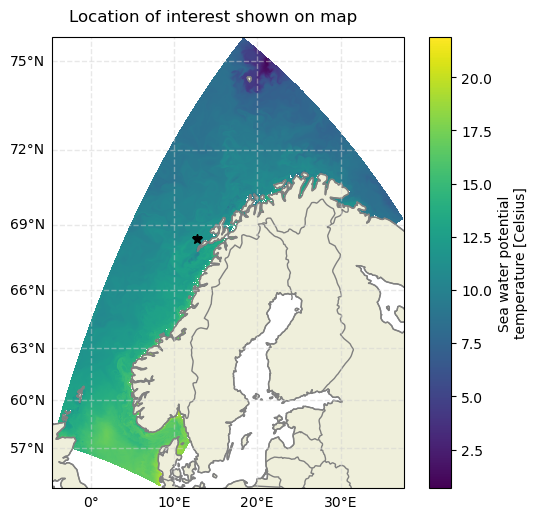

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mercator()}, constrained_layout=True)

# Plotting the temperature field of the first time step, uppermost z-layer and all lats/lons
ds.temperature[0, 0, :, :].plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.set_title('')
# Including a marker for our location
ax.plot(ds.lon[y_idx, x_idx], ds.lat[y_idx, x_idx], '*', transform=ccrs.PlateCarree(), color='black', markersize=7)

# Cosmetics

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False

# Adding elements to our map making it prettier
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', edgecolor= 'gray', scale='50m', facecolor='none')

ax.add_feature(land)
ax.add_feature(coastline)
ax.add_feature(borders)

fig.suptitle('Location of interest shown on map', x=0.5, y=1.05)

From our target location we can retrieve timeseries of various variables using the indices we found. Here are some examples:

Text(0.5, 0.98, 'Temperature and salinity at 0 m depth, loc: (68.35 , 12.72)')

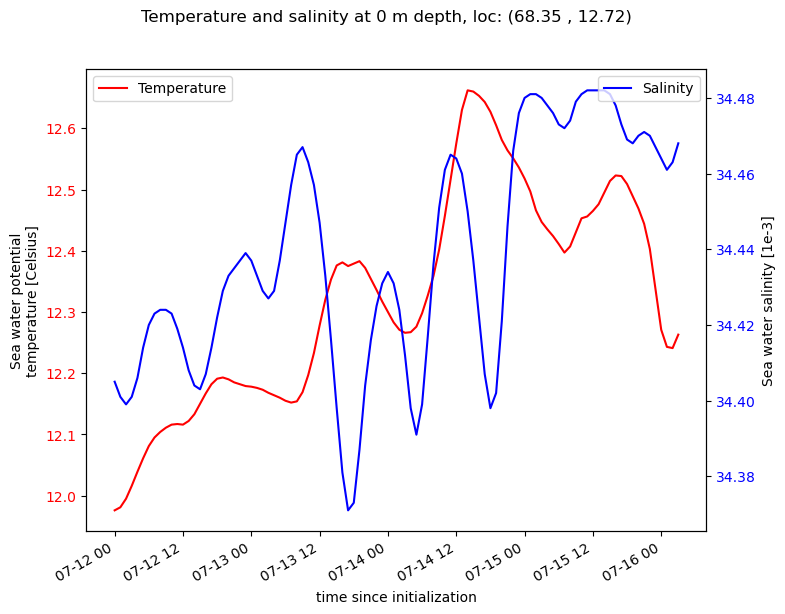

In [9]:
# Simple raw plot of temperature and salinity for the surface layer

fig, ax = plt.subplots(figsize=(8,6))

# First 100 timesteps, uppermost z-level and indices of y and x of location
ds.temperature[0:100, 0, y_idx, x_idx].plot(ax=ax, color='red', label='Temperature') 
ax.tick_params(axis='y', labelcolor='r')
ax.legend(loc='upper left')

ax1 = ax.twinx()  # Sharing x-axis, but different y-axes

# First 100 timesteps, uppermost z-level and indices of y and x of location
ds.salinity[0:100, 0, y_idx, x_idx].plot(ax=ax1, color='blue', label='Salinity')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper right')

# Not very necessary, but removing the default title for a prettier plot:
ax.set_title('')
ax1.set_title('')

fig.suptitle(f'Temperature and salinity at 0 m depth, loc: ({ds.lat[y_idx, x_idx].item():.2f} , {ds.lon[y_idx, x_idx].item():.2f})')

One could also be intersted in looking into the current speeds and directions at a given location:

In the dataset we have the velocities of `u_eastward` and `v_northward`, meaning the velocity components on the lat-lon grid. However, if we want to say anything about the speed in a given point, we have to use that the speed is given by the magnitude of the velocity vector:

$S = |\vec v| = \sqrt{u² + v²}$

In [10]:
current_speed = np.sqrt(ds.u_eastward[0:100, 0, y_idx, x_idx]**2 + ds.v_northward[0:100, 0, y_idx, x_idx]**2)

We can also compare the speed of the uppermost water layer to the wind speed as we have `Uwind_eastward` and `Vwind_northward` given in the dataset.

In [11]:
wind_speed = np.sqrt(ds.Uwind_eastward[0:100, y_idx, x_idx]**2 + ds.Vwind_northward[0:100, y_idx, x_idx]**2)

Text(0.5, 0.98, 'Surface current speed and wind speed at (68.35 N, 12.72 E)')

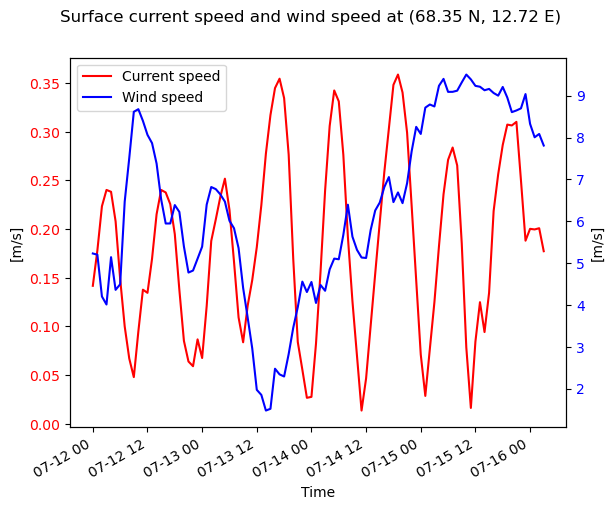

In [12]:
fig, ax = plt.subplots()

line0 = current_speed.plot(ax=ax, color='red', label='Current speed')
ax.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('[m/s]')

ax1 = ax.twinx()  # Sharing x-axis, but different y-axes
ax.set_xlabel('Time')

line1 = wind_speed.plot(ax=ax1, color='blue', label='Wind speed')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('[m/s]')

lines = line0 + line1
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# Not very necessary, but removing the default title:
ax.set_title('')
ax1.set_title('')

fig.suptitle(f'Surface current speed and wind speed at ({ds.lat[y_idx, x_idx].item():.2f} N, {ds.lon[y_idx, x_idx].item():.2f} E)')

Another interesting thing to look at is the direction of the current at a one location over time. To investigate this, we will use the python package `metpy`, which is designed for meteorological usage. Notice that when finding the direction we want to specify `convention='to'` as the default setting of the package is to find the direction of where it is coming from. 

In [13]:
unit = metpy.units.units('m/s')
direction = np.squeeze(metpy.calc.wind_direction(ds.u_eastward[0:100, 0, y_idx, x_idx].values*unit, ds.v_northward[0:100, 0, y_idx, x_idx].values*unit, convention='to'))

If the above calculations of speed was too tedious, we can also employ `metpy.calc.wind_speed` and get the same results.

In [14]:
speed = np.squeeze(metpy.calc.wind_speed(ds.u_eastward[0:100, 0, y_idx, x_idx].values*unit, ds.v_northward[0:100, 0, y_idx, x_idx].values*unit))

The direction as calculated by `metpy` gives us an array with the direction gives as degrees.

(array([20281. , 20281.5, 20282. , 20282.5, 20283. , 20283.5, 20284. ,
        20284.5, 20285. ]),
 [Text(20281.0, 0, '07-12 00'),
  Text(20281.5, 0, '07-12 12'),
  Text(20282.0, 0, '07-13 00'),
  Text(20282.5, 0, '07-13 12'),
  Text(20283.0, 0, '07-14 00'),
  Text(20283.5, 0, '07-14 12'),
  Text(20284.0, 0, '07-15 00'),
  Text(20284.5, 0, '07-15 12'),
  Text(20285.0, 0, '07-16 00')])

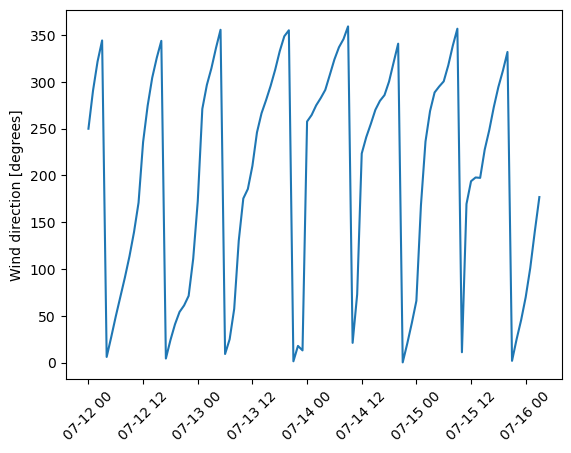

In [ ]:
plt.plot(ds.time[0:100], direction)

plt.ylabel('Wind direction [degrees]')
plt.xticks(rotation=45)

Now, for a more intuitive way of plotting the direction as a time series we can use `plt.quiver`.

In [16]:
time = ds.time[0:100]  # the timesteps we chose for our data
current_direction = np.radians(direction)  # converting from degrees to radians

# Getting the vector components of the direction
x = np.cos(current_direction)
y = np.sin(current_direction)

Text(0.5, 0.9, 'Surface current speed and direction at (68.35 N, 12.72 E)')

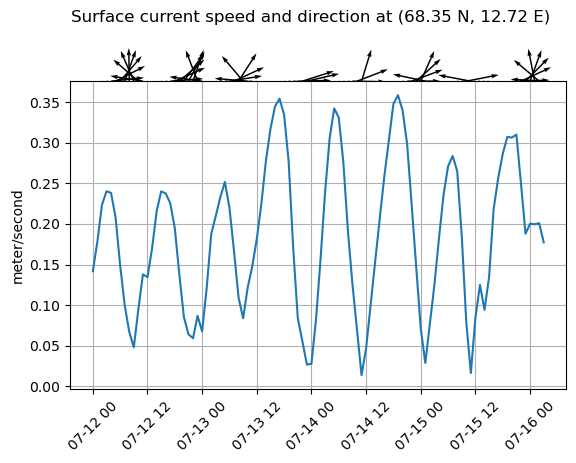

In [22]:
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[1,5]})

ax[0].quiver(time, np.zeros(len(time)), x, y, width=0.003, scale=15)
ax[0].set_ylim([0,0.01])
ax[0].set_yticks([])
ax[0].set_ylabel('Direction')
ax[0].axis('off')

ax[1].plot(time, speed)
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid()

plt.subplots_adjust(hspace=0)

fig.suptitle(f'Surface current speed and direction at ({ds.lat[y_idx, x_idx].item():.2f} N, {ds.lon[y_idx, x_idx].item():.2f} E)', y=0.9)